In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.cluster import KMeans
import scipy
import matplotlib.pyplot as plt
from polire.interpolate import Kriging
import psutil
import multiprocessing as mp
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')

## Beijing Data

In [3]:
if not os.path.exists('beijing_AQI.csv'):
    os.system('wget --no-check-certificate https://raw.githubusercontent.com/patel-zeel/Nonstat-exps/main/data/beijing/beijing_AQI.csv')

## Pre-processing

In [4]:
df = pd.read_csv('beijing_AQI.csv')
df = df.set_index('time').sort_index()
print('unique timestamps are',len(df.index.unique()))
useful_ts = []
for ts in df.index.unique():
  if(len(df.loc[ts])==36):
    useful_ts.append(ts)
df = df.loc[useful_ts]
print('unique timestamps after removing missing entry time-stamps are',len(useful_ts))
df.columns

unique timestamps are 7460
unique timestamps after removing missing entry time-stamps are 2132


Index(['station_id', 'temperature', 'pressure', 'humidity', 'wind_speed',
       'PM25_Concentration', 'latitude', 'longitude', 'weather_0', 'weather_1',
       'weather_10', 'weather_11', 'weather_12', 'weather_13', 'weather_14',
       'weather_15', 'weather_16', 'weather_2', 'weather_3', 'weather_4',
       'weather_5', 'weather_6', 'weather_7', 'weather_8', 'weather_9',
       'wind_direction_0', 'wind_direction_1', 'wind_direction_13',
       'wind_direction_14', 'wind_direction_2', 'wind_direction_23',
       'wind_direction_24', 'wind_direction_3', 'wind_direction_4',
       'wind_direction_9'],
      dtype='object')

## Visualizing data samples

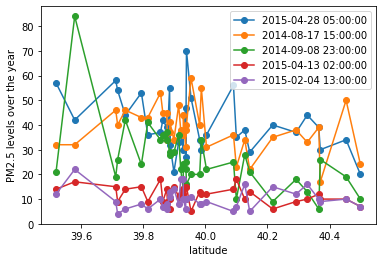

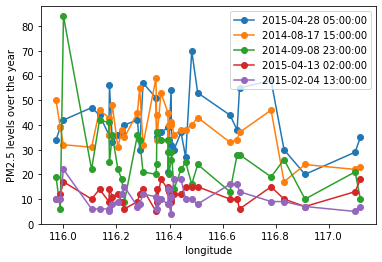

In [5]:
N = 5
sample_ts = df.sample(5, random_state=0).index
for ts in sample_ts:
  tmp_df = df.loc[ts].sort_values('latitude')
  plt.plot(tmp_df.latitude, tmp_df.PM25_Concentration,'o-', label=str(ts))
plt.legend()
plt.xlabel('latitude')
plt.ylabel('PM2.5 levels over the year');

plt.figure()
for ts in sample_ts:
  tmp_df = df.loc[ts].sort_values('longitude')
  plt.plot(tmp_df.longitude, tmp_df.PM25_Concentration,'o-',  label=str(ts))
plt.legend()
plt.xlabel('longitude')
plt.ylabel('PM2.5 levels over the year');

## Train, test split, random state 0

In [6]:
train_stations, test_stations = train_test_split(df.loc[df.index[0]].station_id, 
                                                 train_size=0.85, 
                                                 random_state=0)
print('train_stations', len(train_stations))
print('test_stations', len(test_stations))
df_train = df[df.station_id.isin(train_stations)]
df_test = df[df.station_id.isin(test_stations)]

train_stations 30
test_stations 6


# Experiment for 1 time-stamp

In [7]:
n_ts = 1

# Logitude

## Non-Stat GP

In [8]:
from NSGPy.NumPy import LLS

Started job for N = 1
model, N= 1 ts= 2014-05-01 02:00:00
job finished in 0.01164994239807129 minutes
mean 17.090616724001322 std 0.0
------------------------------
Started job for N = 2
model, N= 2 ts= 2014-05-01 02:00:00
job finished in 0.008705540498097738 minutes
mean 17.44837611560226 std 0.0
------------------------------
Started job for N = 3
model, N= 3 ts= 2014-05-01 02:00:00
job finished in 0.009068143367767335 minutes
mean 17.314419262535264 std 0.0
------------------------------
Started job for N = 4
model, N= 4 ts= 2014-05-01 02:00:00
job finished in 0.008894916375478108 minutes
mean 11.526242913350352 std 0.0
------------------------------
Started job for N = 5
model, N= 5 ts= 2014-05-01 02:00:00
job finished in 0.013523570696512858 minutes
mean 17.632846483824466 std 0.0
------------------------------


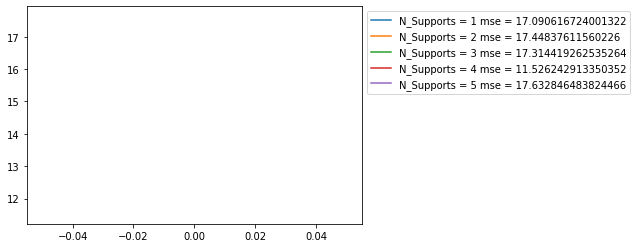

In [14]:
def LLS_it(x):
    ts, N = x
    model = LLS(1, N_l_bar=N)
    model.fit(df_train.loc[ts][['longitude']].values, 
            df_train.loc[ts][['PM25_Concentration']].values)
    pred = model.predict(df_test.loc[ts][['longitude']].values, False)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    ls_test = model.predict_lengthscales_(df_test.loc[ts][['longitude']].values)
    print('model, N=',N,'ts=', ts)
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred, model

for N in [1,2,3,4,5]:
    print('Started job for N =',N)
    init = time()
    workers = mp.Pool(psutil.cpu_count())
    ans = workers.map(LLS_it, zip(df.index.unique()[:n_ts], [N]*n_ts))
    pd.to_pickle(ans, str(N)+'_1N.pickle')
    print('job finished in',(time()-init)/60,'minutes')
    mse = list(map(lambda x:x[0], ans))
    plt.plot(mse, label='N_Supports = '+str(N)+' mse = '+str(np.mean(mse)))
    print('mean',np.mean(mse),'std', np.std(mse))
    print('-'*30)
    workers.terminate()
plt.legend(bbox_to_anchor=(1,1))

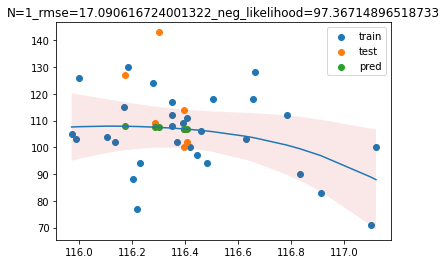

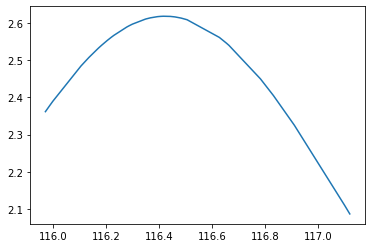

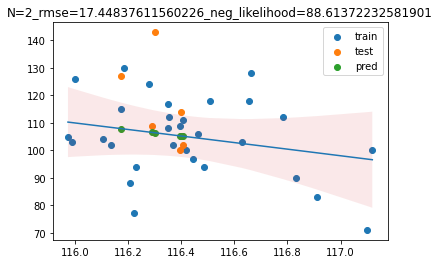

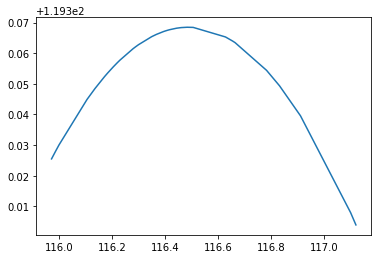

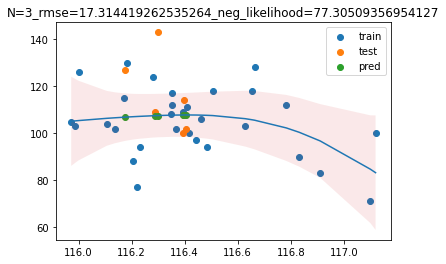

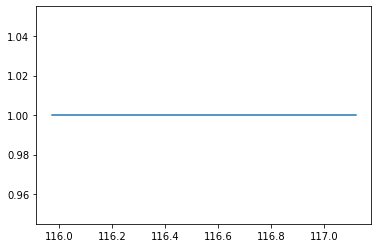

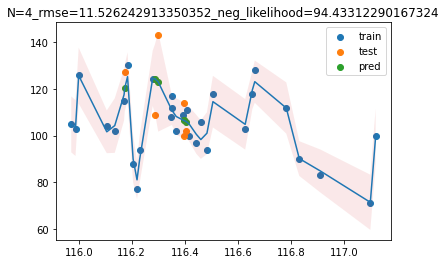

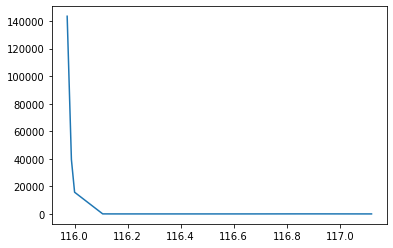

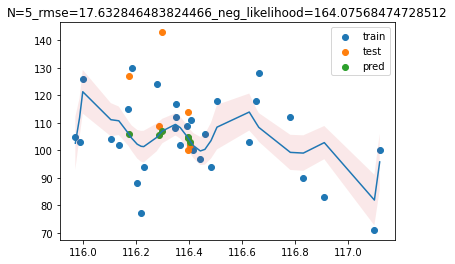

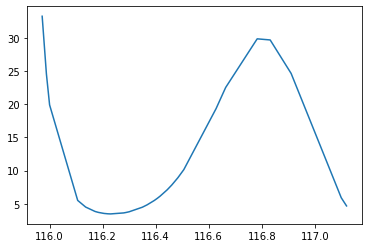

In [25]:
rmse = []
liklihd = []
for N in range(1,6):
    ans = pd.read_pickle(str(N)+'_1N.pickle')
    plt.figure()
    combine = np.concatenate([df_train.loc[df_test.index[0]][['longitude']].values, 
                                        df_test.loc[df_test.index[0]][['longitude']].values])
    combine = np.sort(combine[:,0]).reshape(-1,1)
    model = ans[0][-1]
    plt.scatter(df_train.loc[df_test.index[0]]['longitude'], df_train.loc[df_test.index[0]]['PM25_Concentration'], label='train')
    plt.scatter(df_test.loc[df_test.index[0]]['longitude'], df_test.loc[df_test.index[0]]['PM25_Concentration'], label='test')
    pred, var = model.predict(combine, True)
    plt.scatter(df_test.loc[df_test.index[0]]['longitude'], ans[0][2], label='pred')
    std2 = np.sqrt(var)*2
    plt.plot(combine, pred)
    plt.fill_between(combine.squeeze(), pred.squeeze()-std2.squeeze(), pred.squeeze()+std2.squeeze(), alpha=0.1)
    plt.legend();
    plt.title('N='+str(N)+'_rmse='+str(ans[0][0])+'_neg_likelihood='+str(model.params['likelihood (mll)']))
    plt.figure()
    plt.plot(combine, model.predict_lengthscales_(combine));
    rmse.append(ans[0][0])
    liklihd.append(model.params['likelihood (mll)'])

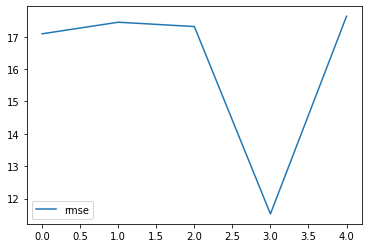

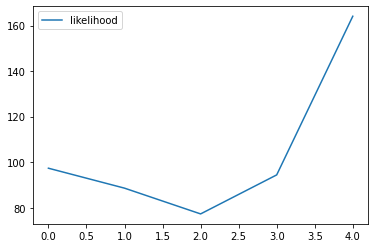

In [27]:
plt.plot(range(5), rmse, label='rmse')
plt.legend()
plt.figure()
plt.plot(range(5), liklihd, label='likelihood')
plt.legend();

# Latitude

## Non-Stat GP

Started job for N = 1
model, N= 1 ts= 2014-05-01 02:00:00
job finished in 0.010809584458669027 minutes
mean 16.335484447264125 std 0.0
------------------------------
Started job for N = 2
model, N= 2 ts= 2014-05-01 02:00:00
job finished in 0.008283889293670655 minutes
mean 16.335489641408184 std 0.0
------------------------------
Started job for N = 3
model, N= 3 ts= 2014-05-01 02:00:00
job finished in 0.009651366869608562 minutes
mean 14.740657388841475 std 0.0
------------------------------
Started job for N = 4
model, N= 4 ts= 2014-05-01 02:00:00
job finished in 0.008845186233520508 minutes
mean 16.335484432379715 std 0.0
------------------------------
Started job for N = 5
model, N= 5 ts= 2014-05-01 02:00:00
job finished in 0.008406134446461995 minutes
mean 16.335485113229286 std 0.0
------------------------------


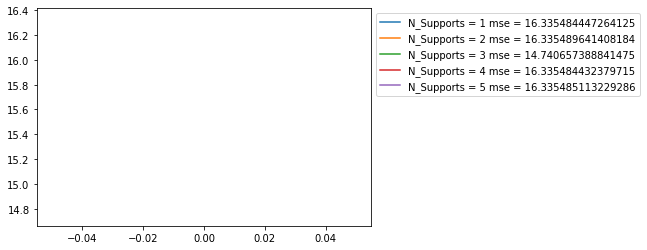

In [35]:
def LLS_it(x):
    ts, N = x
    model = LLS(1, N_l_bar=N)
    model.fit(df_train.loc[ts][['latitude']].values, 
            df_train.loc[ts][['PM25_Concentration']].values)
    pred = model.predict(df_test.loc[ts][['latitude']].values, False)
    test_y = df_test.loc[ts][['PM25_Concentration']].values
    ls_test = model.predict_lengthscales_(df_test.loc[ts][['latitude']].values)
    print('model, N=',N,'ts=', ts)
    return mean_squared_error(test_y.squeeze(), pred.squeeze(), squared=False), test_y, pred, model

for N in [1,2,3,4,5]:
    print('Started job for N =',N)
    init = time()
    workers = mp.Pool(psutil.cpu_count())
    ans = workers.map(LLS_it, zip(df.index.unique()[:n_ts], [N]*n_ts))
    pd.to_pickle(ans, str(N)+'_1N_lat.pickle')
    print('job finished in',(time()-init)/60,'minutes')
    mse = list(map(lambda x:x[0], ans))
    plt.plot(mse, label='N_Supports = '+str(N)+' mse = '+str(np.mean(mse)))
    print('mean',np.mean(mse),'std', np.std(mse))
    print('-'*30)
    workers.terminate()
plt.legend(bbox_to_anchor=(1,1))

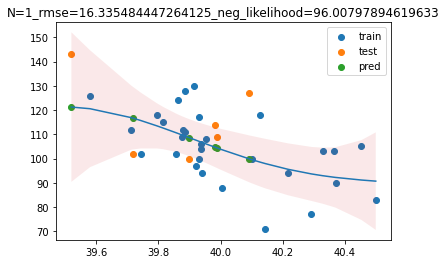

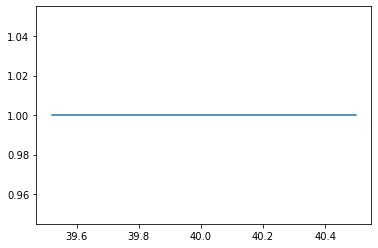

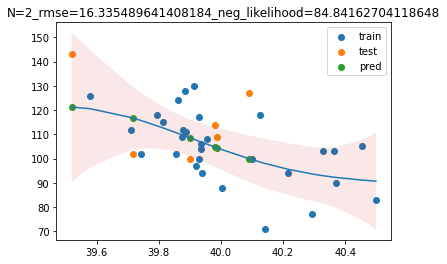

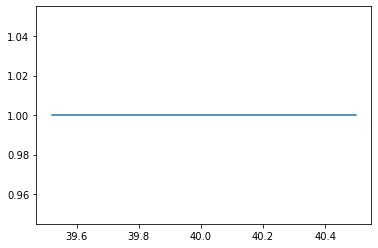

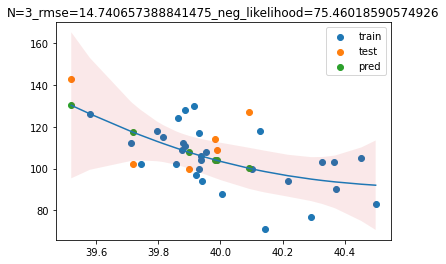

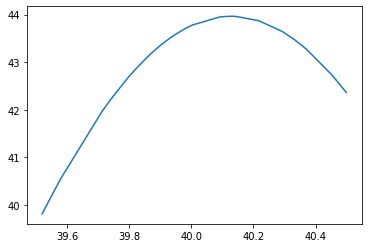

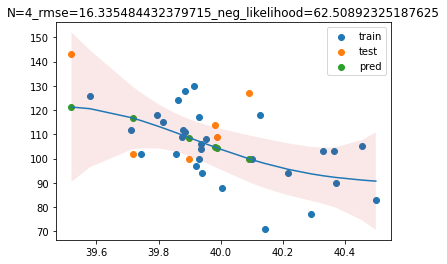

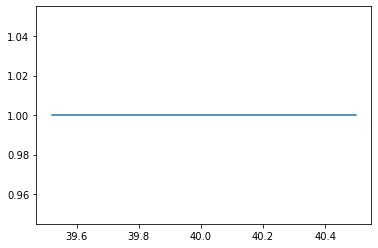

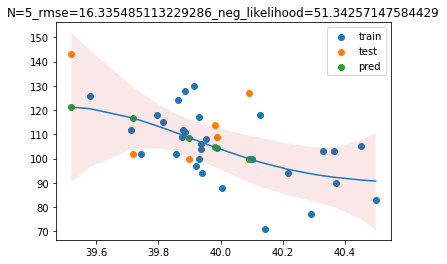

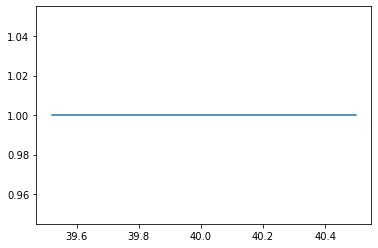

In [36]:
rmse = []
liklihd = []
for N in range(1,6):
    ans = pd.read_pickle(str(N)+'_1N_lat.pickle')
    plt.figure()
    combine = np.concatenate([df_train.loc[df_test.index[0]][['latitude']].values, 
                                        df_test.loc[df_test.index[0]][['latitude']].values])
    combine = np.sort(combine[:,0]).reshape(-1,1)
    model = ans[0][-1]
    plt.scatter(df_train.loc[df_test.index[0]]['latitude'], df_train.loc[df_test.index[0]]['PM25_Concentration'], label='train')
    plt.scatter(df_test.loc[df_test.index[0]]['latitude'], df_test.loc[df_test.index[0]]['PM25_Concentration'], label='test')
    pred, var = model.predict(combine, True)
    plt.scatter(df_test.loc[df_test.index[0]]['latitude'], ans[0][2], label='pred')
    std2 = np.sqrt(var)*2
    plt.plot(combine, pred)
    plt.fill_between(combine.squeeze(), pred.squeeze()-std2.squeeze(), pred.squeeze()+std2.squeeze(), alpha=0.1)
    plt.legend();
    plt.title('N='+str(N)+'_rmse='+str(ans[0][0])+'_neg_likelihood='+str(model.params['likelihood (mll)']))
    plt.figure()
    plt.plot(combine, model.predict_lengthscales_(combine));
    rmse.append(ans[0][0])
    liklihd.append(model.params['likelihood (mll)'])

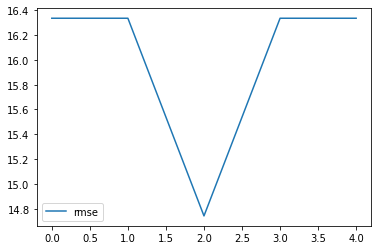

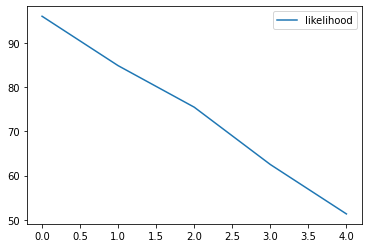

In [38]:
plt.plot(range(5), rmse, label='rmse')
plt.legend()
plt.figure()
plt.plot(range(5), liklihd, label='likelihood')
plt.legend();